# <center> Tâche 1 de la pipeline : transcription des audios à l'écrit</center>

A partir de nos données audios (générées dans le notebook *Dataset_Creation*), nous allons les transcrire à l'écrit en utilisant un modèle de *speech to text*. Le **défi** ici est de parvenir à transcrire les audios en conservant les erreurs afin de permettre à l'utilisateur de visualiser ses erreurs dans le texte, et par la suite le texte corrigé. Le problème est que la plupart des modèles de *speech to text* possèdent une couche de traitement de la langue leur permettant de corriger les fautes. Un **autre défi** auquel nous allons faire face est l'affinnage du modèle, pour tenter d'augmenter ses performances en particulier sur l'accent indien.

## Import des packages

In [1]:
!pip install -U -q gTTS datasets import_ipynb jiwer #Pour WER metric
!pip install -U -q transformers[torch] # penser a redemarrer la session pour la prise en compte du package

In [2]:
import pandas as pd
import os, torchaudio,torch

from datasets import load_dataset, concatenate_datasets, Dataset, DatasetDict, load_metric
from datasets.features.audio import Audio
from dataclasses import dataclass
from typing import Any, Dict, List, Union

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, pipeline, Seq2SeqTrainingArguments, Seq2SeqTrainer, WhisperForConditionalGeneration

import matplotlib.pyplot as plt

from gtts import gTTS
from IPython.display import Audio

import import_ipynb
from Dataset_Creation import dataset_concat, nb_audio, audio_folder # import de variables provenant de l'autre notebook

from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset

from transformers.models.whisper.english_normalizer import BasicTextNormalizer

from huggingface_hub import notebook_login
from transformers import WhisperProcessor

from functools import partial

importing Jupyter notebook from Dataset_Creation.ipynb
Les retranscriptions audios se trouvent dans le dossier 'audio'. 
Nombre total d'audio créé: 1141 sur 1501 textes du jeu de données JFLEG


## Creation du jeu de données
On commence par créer notre jeu de données comportant les audios précédents et leur transcriptions associées. Le but ici est de créer un jeu de données qui servira pour l'affinnage de notre STT.

In [3]:
# CREATION METADATA (doc hugging face :https://huggingface.co/docs/datasets/audio_load)

metadata_csv_path = os.path.join(audio_folder, "metadata.csv")

if not os.path.exists(metadata_csv_path):
  # Liste des chemins des fichiers audio
  audio_files = [f"{i}.mp3" for i in range(0, nb_audio)]
  # Transcriptions associées
  transcriptions = dataset_concat["sentence"][:nb_audio]
  # Créer un DataFrame avec les noms de fichiers et les transcriptions
  df = pd.DataFrame({"file_name": audio_files, "transcription": transcriptions})
  # Enregistrer le DataFrame dans un fichier CSV
  df.to_csv(metadata_csv_path, index=False)
  print(f"Metadata CSV enregistré à : {metadata_csv_path}")
else:
  print("Le fichier metadata.csv existe déjà")

# CREATION DU LOAD_DATASET
dataset = load_dataset("audiofolder", data_dir=audio_folder, split="train")

Le fichier metadata.csv existe déjà


Resolving data files:   0%|          | 0/1142 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Prétraitement des données

### 1. Rééchantillonnage

Nos données avaient initialement un taux d'échantillonnage (*sampling_rate*) de 24KHz, or le modèle STT d'Hugging face a besoin d'un taux de 16KHz (doc : https://huggingface.co/facebook/wav2vec2-base-960h). On a donc fait un rééchantillonnage (à ne faire qu'une fois).

In [17]:
# Liste des chemins des fichiers audio
audio_files = [os.path.join(audio_folder, f"{i}.mp3") for i in range(0, nb_audio)]

# Rééchantillonnage des fichiers audio à 16000 Hz
target_sampling_rate = 16000
resample_transform = torchaudio.transforms.Resample(orig_freq=24000, new_freq=target_sampling_rate)

# Rééchantillonner et sauvegarder chaque fichier audio
for audio_file in audio_files:
    # Charger l'audio
    waveform, original_sampling_rate = torchaudio.load(audio_file, normalize=True)

    if original_sampling_rate != 16000:
      # Rééchantillonner l'audio
      resampled_waveform = resample_transform(waveform)
      # Sauvegarder l'audio rééchantillonné dans un nouveau fichier
      new_audio_file = os.path.join(audio_folder, os.path.basename(audio_file))
      torchaudio.save(new_audio_file, resampled_waveform, target_sampling_rate)
    else:
      print("audio déjà rééchantilloné")
    # print(f"Audio rééchantillonné enregistré : {new_audio_file}")


audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà rééchantilloné
audio déjà r

Nos données sont maintenant bien échantillonées à 16KHz.

### 2. Division en jeu d'entrainement et de test

In [4]:
# Diviser l'ensemble de données en portions "train" et "test"
train_percentage = 0.8
train_size = int(len(dataset) * train_percentage)

# Créer un DatasetDict
dataset_dict = DatasetDict({
    "train": dataset.select(range(train_size)),
    "test": dataset.select(range(train_size, len(dataset)))
})

# Charger la portion "train"
train_dataset = dataset_dict["train"]

# Charger la portion "test"
test_dataset = dataset_dict["test"]

print(train_dataset)
print(test_dataset)

Dataset({
    features: ['audio', 'transcription'],
    num_rows: 912
})
Dataset({
    features: ['audio', 'transcription'],
    num_rows: 229
})


___
## Choix des modèles

On va maintenant comparer deux modèles de ASR (*automatic speech recognition*) : l'un comportant une couche de traitement de la langue, et l'autre non. On veut trouver un modèle pour cette tâche qui ne corrige pas déjà les fautes de grammaire qui sont audibles dans les audios. Ces deux modèles sont les suivants :
- **Wav2Vec2** (uniquement basé sur la phonétique)
- **Whisper** (possédant une couche de traitement de la langue)

Testons les deux modèles sur un exemple de notre dataset pour avoir un apperçu de leur comportement.

Echantillon de test:

In [5]:
sample = dataset[4] # échantillon pour tester le modèle
Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

#### Test du modèle Wav2Vec2 :

In [ ]:
pipe_wav2vec2 = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-100h")
prediction_wav2vec2 =  pipe_wav2vec2(sample["audio"].copy())["text"]
reference = sample["transcription"]

print("\nPrediction à partir de l'audio :", prediction_wav2vec2)
print("Phrase réelle associée à l'audio :", reference)

Some weights of the model checkpoint at facebook/wav2vec2-base-100h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.mask_time_emb_vector', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav


Prediction à partir de l'audio : I DON'T HAVE A GARB BUT I DREAMING IT OFF
Phrase réelle associée à l'audio : I dont have a car but i dreaming it off .


#### Test du modèle Whisper :

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

pipe_whisper = pipeline(
    "automatic-speech-recognition", model="openai/whisper-base", device=device
)
prediction_whisper = pipe_whisper(sample["audio"].copy(), max_new_tokens=256)["text"]

print("\nPrediction à partir de l'audio :", prediction_whisper)
print("Phrase réelle associée à l'audio :", reference)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



Prediction à partir de l'audio :  I don't have a car but I dreaming it off.
Phrase réelle associée à l'audio : I dont have a car but i dreaming it off .


#### Analyse
Il semble que le modèle Whisper fonctionne mieux que le Wav2Vec2. En effet, le traitement de la langue présent dans Whisper permet de n'obtenir en sortie que des mots qui existent dans le vocabulaire anglais, contrairement à Wav2Vec2 qui ne fonctionne qu'à la phonétique et qui donc retranscrit des mots inexistants. De plus, Whisper semble tout de même retranscrire les erreurs grammaticales comme sur l'exemple ci-dessus. On va calculer le WER de chacun des deux modèles sur nos données pour confirmer cette hypothèse.


#### Normalisation
On peut normaliser nos prédictions avant de calculer le WER pour ne pas compter les fautes de ponctuation (seul le modèle whisper est concerné car wav2vec2 n'est pas un modèle orthographique). En effet dans notre cas nous nous intéressons surtout à la bonne retranscription des mots et des fautes de grammaire, mais pas à la ponctuation. Aussi dans l'exemple précédent avec whisper on peut voir qu'un point a été ajouté avant le dernier mot de la phrase dans la prédiction ce qui a un impact sur le WER, or la normalisation permettra par exemple de supprimer ce point et la majuscule qui suit et ainsi obtenir une meilleure métrique.

In [ ]:
normalizer = BasicTextNormalizer()

prediction = prediction_whisper
normalized_prediction = normalizer(prediction)

print(prediction_whisper)
print(normalized_prediction)

 So I think we cannot live if old people could not find sciences and technologies and they did not. Developed
 so i think we cannot live if old people could not find sciences and technologies and they did not developed


In [ ]:
wer_metric = load_metric("wer")
wer = wer_metric.compute(references=[reference], predictions=[normalized_prediction])
wer

0.36363636363636365

In [ ]:
print(reference)
print(prediction_whisper)
print(normalized_prediction)

So I think we can not live if old people could not find siences and tecnologies and they did not developped . 
 So I think we cannot live if old people could not find sciences and technologies and they did not. Developed
 so i think we cannot live if old people could not find sciences and technologies and they did not developed


___
## Evaluation des modèles ASR sur les données de test

In [6]:
def speech_recognition_inference(dataset, pipe, batch_size):
  all_predictions = []

  for prediction in tqdm(pipe(
          KeyDataset(dataset, "audio"),
          max_new_tokens=256,
          generate_kwargs={"task": "transcribe"},
          batch_size=batch_size,
      ),
      total=len(dataset),
  ):
      all_predictions.append(prediction["text"])
      del prediction # release useless variables from memory (to have more space)

  return all_predictions

Pour que l'inférence avec Wav2Vec2 se fasse malgré une quantité de mémoire RAM limitée, on doit mettre des petits batchs (`batch_size`) pour limiter le nombre de calculs qui se font en parallèle, donc ici on choisit 8 :

In [10]:
pipe_wav2vec2 = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-100h")
predictions_wav2vec2 = speech_recognition_inference(test_dataset, pipe_wav2vec2, 8)

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base-100h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.mask_time_emb_vector', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametriz

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/358 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

100%|██████████| 229/229 [17:07<00:00,  4.48s/it]


Pour Whisper, on peut utiliser le GPU donc on peut mettre un `batch_size`plus élevé, on choisit 32 :

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

pipe_whisper_small = pipeline("automatic-speech-recognition", model="openai/whisper-small", device=device)
predictions_whisper_small = speech_recognition_inference(test_dataset, pipe_whisper_small, 32)

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.84k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

100%|██████████| 229/229 [00:59<00:00,  3.86it/s]


On calcule maintenant le WER pour les deux modèles.

In [8]:
def compute_wer(references, predictions, isNormalisation):
  wer_metric = load_metric("wer")
  if isNormalisation is False:
    wer = 100 * wer_metric.compute(references=references, predictions=predictions)
  else :
    normalizer = BasicTextNormalizer()
    predictions_norm = [normalizer(pred) for pred in predictions]
    references_norm = [normalizer(ref) for ref in references]
    wer = 100 * wer_metric.compute(references=references_norm, predictions=predictions_norm)

  return wer

Le modèle Wav2Vec2 n'est pas un modèle orthographique, c'est-à-dire qu'il ne fait pas de transcription avec de la ponctuation. De plus sa sortie est tout en majuscule. On est donc obligé de normaliser les références et les inférences pour pouvoir calculer la WER (car les références contiennent de la ponctuation) :

In [11]:
wer_norm_wav2vec2 = compute_wer(test_dataset["transcription"], predictions_wav2vec2, True)
print("Modèle Wav2Vec2 :")
print("WER avec normalisation:", wer_norm_wav2vec2)

Modèle Wav2Vec2 :
WER avec normalisation: 19.095849802371543


Pour le modèle Whisper on va calculer la WER sans puis avec normalisation pour voir la différence, mais ce qui nous intéresse est la valeur avec normalisation :

In [9]:
wer_ortho_small = compute_wer(test_dataset["transcription"], predictions_whisper_small, False)
wer_norm_small = compute_wer(test_dataset["transcription"], predictions_whisper_small, True)
print("Modèle Whisper SMALL:")
print("WER sans normalisation :", wer_ortho_small)
print("WER avec normalisation :", wer_norm_small)

<ipython-input-8-ee534639af34>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


Modèle Whisper SMALL:
WER sans normalisation : 26.558631555255456
WER avec normalisation : 7.114624505928854


Finalement, notre hypothèse comme quoi le modèle Whisper est meilleur dans notre cas que le modèle Wav2Vec2 est validée. On observe que la WER de Wav2Vec2 est de 19% et celle de Whisper, après normalisation, de 7%. Cela signifie que le modèle Whisper est parvenue à retranscrire les audios de manière correcte, tout en prenant en compte les erreurs grammaticales qui y sont présentes.

___
## Fine tunning du modèle Whisper

Nous allons faire un fine tunning sur notre modèle pour améliorer ses performances, en particulier sur nos audios qui sont des audios de personne parlant anglais avec l'accent indien. Nous allons essayer d'obtenir un meilleur WER par rapport à celui de 7% obtenu précédemment.

On se connecte au hub de hugging face pour enregistrer les checkpoint lors de l'entrainement **(cette étape nécessite d'avoir un compte sur HuggingFace et d'utiliser un token pour s'y connecter)**.

In [ ]:
notebook_login()

### Prétraitement des audios

In [12]:
processor = WhisperProcessor.from_pretrained("openai/whisper-small")

On commence par calculer le log_mel spectrogramme des audios grâce au feature extractor de Whisper, on encode les phrases de référence (`transcription`) grâce au tokeniseur.

In [13]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        audio=audio["array"],
        sampling_rate=audio["sampling_rate"],
        text=example["transcription"],
    )

    # compute input length of audio sample in seconds
    example["input_length"] = len(audio["array"]) / audio["sampling_rate"]

    return example

In [14]:
train_dataset_preprocess = train_dataset.map(prepare_dataset, remove_columns=train_dataset.column_names, num_proc=1) # on ne garde que les colonnes créées par la fonction
train_dataset_preprocess

Map:   0%|          | 0/912 [00:00<?, ? examples/s]

Dataset({
    features: ['input_features', 'labels', 'input_length'],
    num_rows: 912
})

In [15]:
test_dataset_preprocess = test_dataset.map(prepare_dataset, remove_columns=test_dataset.column_names, num_proc=1) # on ne garde que les colonnes créées par la fonction
test_dataset_preprocess

Map:   0%|          | 0/229 [00:00<?, ? examples/s]

Dataset({
    features: ['input_features', 'labels', 'input_length'],
    num_rows: 229
})

Ensuite on filtre pour ne garder que les audios de moins de 30 secondes, car s'ils sont plus longs ils seraient tronqués par le feature extractor de  Whisper ce qui pourrait affecter la stabilité de l'entrainement.

In [16]:
max_input_length = 30.0

def is_audio_in_length_range(length):
    return length < max_input_length

train_dataset_preprocess = train_dataset_preprocess.filter(
    is_audio_in_length_range,
    input_columns=["input_length"],
)

print(train_dataset_preprocess)


test_dataset_preprocess = test_dataset_preprocess.filter(
    is_audio_in_length_range,
    input_columns=["input_length"],
)

print(test_dataset_preprocess)

Filter:   0%|          | 0/912 [00:00<?, ? examples/s]

Dataset({
    features: ['input_features', 'labels', 'input_length'],
    num_rows: 912
})


Filter:   0%|          | 0/229 [00:00<?, ? examples/s]

Dataset({
    features: ['input_features', 'labels', 'input_length'],
    num_rows: 229
})


Finalement on voit qu'on a toujours 912 et 229 audios pour les données d'entrainement et de test respectivement après le filtre donc aucun audios ne fait plus de 30 secondes.

### Entrainement

On construit un Data Collator qui prépare les données pour le modèle :

In [ ]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

On crée la fonction qui va calculer les métriques d'évaluation du modèle, en particulier le WER sans normalisation et le WER avec normalisation.

In [ ]:
normalizer = BasicTextNormalizer()
metric = load_metric("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # compute orthographic wer
    wer_ortho = 100 * metric.compute(predictions=pred_str, references=label_str)

    # compute normalised WER
    pred_str_norm = [normalizer(pred) for pred in pred_str]
    label_str_norm = [normalizer(label) for label in label_str]
    # filtering step to only evaluate the samples that correspond to non-zero references:
    pred_str_norm = [
        pred_str_norm[i] for i in range(len(pred_str_norm)) if len(label_str_norm[i]) > 0
    ]
    label_str_norm = [
        label_str_norm[i]
        for i in range(len(label_str_norm))
        if len(label_str_norm[i]) > 0
    ]

    wer = 100 * metric.compute(predictions=pred_str_norm, references=label_str_norm)

    return {"wer_ortho": wer_ortho, "wer": wer}

Ensuite on charge le modèle Whisper pré-entrainé :

In [ ]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(
    model.generate, use_cache=True
)

On configure l'entrainement pour 200 steps (ce qui représente 4 epochs) :

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-dv",  # name on the HF Hub
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    lr_scheduler_type="constant_with_warmup",
    warmup_steps=50,
    max_steps=200,
    gradient_checkpointing=True,
    fp16=True,
    fp16_full_eval=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=200,
    eval_steps=200,
    logging_steps=1, # saving loss steps
    report_to=["tensorboard"],
    load_best_model_at_end=False,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset_preprocess,
    eval_dataset=test_dataset_preprocess,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer Ortho,Wer
200,0.117700,0.324289,7.359892,5.187747


TrainOutput(global_step=200, training_loss=0.9211949175409972, metrics={'train_runtime': 1356.5416, 'train_samples_per_second': 2.359, 'train_steps_per_second': 0.147, 'total_flos': 9.23473281024e+17, 'train_loss': 0.9211949175409972, 'epoch': 3.51})

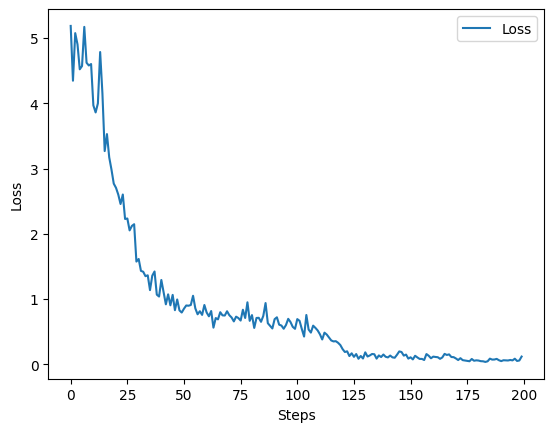

In [ ]:
train_log = int(200)
log = trainer.state.log_history
# log[:train_log]

all_loss = []

for element in log[:train_log]:
  all_loss.append(element["loss"])

# Plot the loss over epochs
plt.plot(all_loss, label="Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

Finalement, grâce à l'affinnage du modèle, on parvient à un WER d'environ 5%, ce qui est meilleur que le 7% obtenu sans affinnage. De plus, bien que nous n'ayons affiné que sur 200 steps (4 epochs) pour des raisons de limitation de mémoire, on observe tout de même une belle baisse de la perte qui passe de 5 à presque 0.